In [1]:
from datetime import datetime, time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
parent_dir = os.getcwd()
path = os.path.dirname(parent_dir)
sys.path.append(path)

from data.data_utils import DataLoader, ConfigParser
from models.battery_simulator import battery

In [2]:

class reward:
    
    
    def __init__(self):
        """
        Initialize the reward module. 
        
        args: 
        
        """
        #self.region = region
        #self.tariff_type = tariff_type
        #self.export_tariff = export_tariff
        
        self.TOU = {
            "VIC":{"peak": 0.3021, "shoulder": 0.1735, "off-peak": 0.1735, 'solar':0.052, 'connection': 1.1623},
            "NSW":{"peak": 0.6234, "shoulder": 0.2839, "off-peak": 0.1642, 'solar':0.050, 'connection': 1.0480},
            "QLD":{"peak": 0.3566, "shoulder": 0.2500, "off-peak": 0.2032, 'solar':0.050, 'connection': 1.2180},
            "SA":{"peak": 0.4435, "shoulder": 0.2178, "off-peak": 0.2633, 'solar':0.050, 'connection': 0.9514}
        }
        
    def get_tariff_rate(self, current_timestamp, region):
        """
        Returns the Tariff Rate for a given region and timestamp, based on the ToU dict.
        
        inputs:
            current_timestamp (datetime.datetime): The time stamp including date and time. 
            region (str)
            
        return (float): The rate in $/kWh
        
        """
    
        current_time = current_timestamp.time()
        
        if region == 'VIC':
            # Only peak or shoulder/off-peak
            if self.time_between(time(15,0), time(21,0), current_time):
                return self.TOU['VIC']['peak']
            else: #shoulder/off-peak - either doesn't matter.
                return self.TOU['VIC']['shoulder']
            
        elif region == 'SA':
            # Determine whether peak, shoulder or off-peak
            if self.time_between(time(6,0), time(10,0), current_time) or self.time_between(time(15,0), time(1,0), current_time):                
                return self.TOU['SA']['peak']
            elif self.time_between(time(1,0), time(6,0), current_time):
                return self.TOU['SA']['off-peak']
            else: #shoulder
                return self.TOU['SA']['shoulder']
        
        else:
            # Either NSW or QLD which have weekday dependent peaks
            dow = current_timestamp.weekday()
            if region == 'QLD':
                if self.time_between(time(22,0), time(7,0), current_time):
                    return self.TOU['QLD']['off-peak']
                elif dow < 5 and self.time_between(time(16,0), time(20,0), current_time):
                    return self.TOU['QLD']['peak']
                else:
                    return self.TOU['QLD']['shoulder']
            
            elif region == 'NSW':
                # NSW only has a peak in winter and autum
                month = current_timestamp.month
                if self.time_between(time(22,0), time(7,0), current_time):
                    return self.TOU['NSW']['off-peak']
                # If it's a weekday, in peak time during the months of Summer or Winter. 
                elif dow < 5 and self.time_between(time(14,0), time(20,0), current_time) and month in [1,2,3,6,7,8,12]:
                    return self.TOU['NSW']['peak']
                else:
                    return self.TOU['NSW']['shoulder']             
            else:
                print('unknown region!')
                
            
    def get_solar_fit(self, region):
        """
        Returns the rate of reward for solar power exported in $/kWh by region
        region (str): The state as string
        """
        return self.TOU[f'{region}']['solar']
    
    def get_connection_fee(self, region):
        """
        Returns the daily connection fee in $/day
        region (str): The state as string
        
        """
        return self.TOU[f'{region}']['connection']         

    def time_between(self, begin_time, end_time, check_time):
        """
        Checks if a time is between two times. 
        from https://stackoverflow.com/questions/10048249/how-do-i-determine-if-current-time-is-within-a-specified-range-using-pythons-da

        """

        check_time = check_time
        if begin_time < end_time:
            return check_time >= begin_time and check_time <= end_time
        else: # crosses midnight
            return check_time >= begin_time or check_time <= end_time

def get_month(dt):
    
    m_sin = np.sin(2 * np.pi * dt.month / 12)
    m_cos = np.cos(2 * np.pi * dt.month / 12)

    return m_cos, m_sin

def polar_time(dt, interval=5):
    """
    Takes a timestamp as input and returns the time in time
    """

    current_m = dt.minute
    # Get utc offset in seconds
    utc_offset = dt.utcoffset()
    if utc_offset == 10.5 * 60 * 60 or utc_offset == 11 * 60 * 60:
        if dt.hour == 0:
            current_hour = 23
        else:
            current_h = dt.hour - 1
    else:
        current_h = dt.hour

    n_intervals = 24 * 60 / interval

    g_min = int((current_h * 60 / interval) + (current_m // interval))
    t_sin = np.sin(2 * np.pi * g_min / n_intervals)
    t_cos = np.cos(2 * np.pi * g_min / n_intervals)
    
    return t_cos, t_sin

def encode_region(region):

    if region == 'NSW':
        return [0,0,0]
    elif region == 'VIC':
        return [1,0,0]
    elif region == 'QLD':
        return [0,1,0]
    elif region == 'SA':
        return [0,0,1]
    else:
        raise Exception(f'Region {region} not recognised!')


In [3]:
def calculate_grid_load(solar, home, max_discharge, max_charge, scenario):
    """
    Function to return the action for the battery based off some strongly defined programming
    logic.
    args:
     solar - solar output at that time. Float, negative.
     home - household loads at that time Float, positive.
     max_discharge - discharge potential float, negative. ### Note the current code assumes positive.
     max_charge - charge potential of the battery float, positive.
     senario - string, describes which scenario is being modelled.
    
    """
    
    # Here the sign counts - make solar negative. 
    if solar > 0:
        solar = solar * -1
        
    net = home + solar
    
    if scenario == 'StatusQuo':
        """
        Battery cannot export or import energy.
        Must charge from solar and take max possible,
        Must meet loads to fullest extent.
        """
        
        # Surplus Load - we need to either import and/or discharge  
        if net > 0:
            state = 'discharge'
            if abs(max_discharge) >= net: # Deficit met by battery
                bat_output = - net
                grid = 0
            elif abs(max_discharge) < net: # Deficit not fully met by battery, need to import
                bat_output = max_discharge
                grid = net + bat_output

        # Surplus Solar - we need to either export, and/or charge
        elif net <= 0:
            state = 'charge'
            if max_charge > abs(net): # Soak up all the excess solar, no export
                bat_output = - net
                grid = 0
            elif max_charge <= abs(net): # Soak up as much as we can, export the rest of the solar.
                bat_output = max_charge
                grid = net + bat_output

        else: # No load or solar, net = 0
            raise Exception
    
    return grid, state, bat_output

In [4]:
# Load data and metadata

# Parse config required for loading the data
config_dict = {
    "pricing_env": "simple",
    "max_devices": 200
} 
config = ConfigParser(config_dict)
for k,v in config_dict.items():
    setattr(config, k, v)

# Load the files
file_loader = DataLoader(config, 'test')
device_list = file_loader.device_list

Invalid input, defaulting to number of found devices
Found 150 devices


Run a few  Simulations

In [5]:


## Create some new columns to collect actions
def create_result_dict():
    return  {
        'Timestamp':[], 'DeviceID':[], 'Solar':[], 'Home':[], 'Tariff':[], 'Solar Tariff':[],
        'Battery Capacity':[],'Battery Available Energy':[], 'Grid Simulated':[], 
        'Action':[],'State':[], 'Limits':[], 'Reward':[]
    } 

result_dict = create_result_dict()

result_summary = {
    'Device':[], 'Reward_Total': [], "N_Days":[], 'Mean_Daily_Cost':[]
}

verbose = False
num_devices_to_try = 200 # Set to greater than num devices to do all
save_path = "results/benchmarks/simple_wbattery/test/"
save_dict = False
num_devices = 0
result_list = []

for device in device_list:     
    
    # Load Data
    device_data = file_loader.load_device(device)
    
    reward = 0
    reward_total = 0
    if verbose:
        print(f'Device: {device}')
    
    bat = None
    k = 0 #
    for m in device_data.index:

        # Get Solar, and Load, caculate the net energy
        sol = device_data.loc[m]['solar']
        hom = device_data.loc[m]['loads']
        ToU = device_data.loc[m]['import_tariff']
        sToU = device_data.loc[m]['export_tariff']
        
        net = hom + sol 

        # Instantiate Battery the first time - DOUBLE CHECK CLASSES!
        if bat == None:
            bat = battery(capacity=14, exportable=False, importable=False, start_soc='full')
            bat.avl_energy = 14 # kWh
            if verbose:
                print(f'Battery Initialised: Available Energy {bat.avl_energy} kWh')

        # Get discharge/charge limits from the battery:
        a_d, a_c = bat.get_limits(sol, hom)
        
        # Update Resolve Action
        grid, state, bat_out = calculate_grid_load(sol, hom, a_d, a_c, 'StatusQuo' )

        # Update State
        if state == 'charge':
            bat.charge(bat_out)
            reward = grid * sToU
        elif state == 'discharge':
            bat.discharge(bat_out)
            reward = grid * ToU * -1
        else:
            print('Unresolved charge/discharge')
        
        reward_total += reward
        
        if verbose:
            print(f'Solar: {sol}, Home: {hom}, Net: {net}, Grid: {grid}')
            print(f"Bat Capacity: {bat.avl_energy:.4f}, Limits: {a_d}/{a_c},  Action:{state} {bat_out}")
            print(f"reward: {reward}")
            print('-----')
        
        # Write values to results dictionary:
        i = 0
        val = [m, device, sol, hom, ToU, sToU, bat.capacity, bat.avl_energy, grid, bat_out,state, (a_d, a_c), reward]
        for key in result_dict:
            result_dict[key].append(val[i])
            i += 1
        k += 1

    n_days = k /(12*24)
    average_daily_cost = reward_total/n_days

    # Write Aggregated Summary
    i = 0
    val = [device, reward_total, n_days, average_daily_cost]
    for key in result_summary:
        result_summary[key].append(val[i])
        i += 1
    print(f'Revised bill: ${reward_total:.2f} for device: {device} for '
         f'{n_days:.2f} days or ${average_daily_cost:.2f}/day') 
    
    num_devices += 1
    if num_devices >= num_devices_to_try:
        break

print('done!')

print('Saving Summary')
# Save Result Summary:
summary_df = pd.DataFrame(result_summary)
summary_df.to_parquet(save_path+f"summary_simple_wbatt_statusquo_test.parquet")

print('Saving Detail')
# Write Main DF
combined_result_df = pd.DataFrame(result_dict)
combined_result_df.to_parquet(save_path+f"detailed_simple_wbatt_statusquo_test.parquet")
print('Done!')


loaded 20300 steps from DD04108401266_simple_test.parquet
Revised bill: $25.48 for device: DD04108401266 for 70.49 days or $0.36/day
loaded 19424 steps from DD04108624381_simple_test.parquet
Revised bill: $5.89 for device: DD04108624381 for 67.44 days or $0.09/day
loaded 20314 steps from DD04108624683_simple_test.parquet
Revised bill: $-89.48 for device: DD04108624683 for 70.53 days or $-1.27/day
loaded 20315 steps from DD04108625556_simple_test.parquet
Revised bill: $-209.44 for device: DD04108625556 for 70.54 days or $-2.97/day
loaded 20316 steps from DD04108627065_simple_test.parquet
Revised bill: $22.44 for device: DD04108627065 for 70.54 days or $0.32/day
loaded 20316 steps from DD04108627645_simple_test.parquet
Revised bill: $3.60 for device: DD04108627645 for 70.54 days or $0.05/day
loaded 19426 steps from DD04108746744_simple_test.parquet
Revised bill: $-12.81 for device: DD04108746744 for 67.45 days or $-0.19/day
loaded 20318 steps from DD04108747038_simple_test.parquet
Revise

Revised bill: $7.36 for device: DD64108397465 for 70.67 days or $0.10/day
loaded 20354 steps from DD64108399284_simple_test.parquet
Revised bill: $-58.77 for device: DD64108399284 for 70.67 days or $-0.83/day
loaded 20354 steps from DD64108401501_simple_test.parquet
Revised bill: $-111.70 for device: DD64108401501 for 70.67 days or $-1.58/day
loaded 20322 steps from DD64108624151_simple_test.parquet
Revised bill: $29.30 for device: DD64108624151 for 70.56 days or $0.42/day
loaded 20356 steps from DD64108626772_simple_test.parquet
Revised bill: $-115.40 for device: DD64108626772 for 70.68 days or $-1.63/day
loaded 20356 steps from DD64108742682_simple_test.parquet
Revised bill: $-75.12 for device: DD64108742682 for 70.68 days or $-1.06/day
loaded 20357 steps from DD64108744906_simple_test.parquet
Revised bill: $32.69 for device: DD64108744906 for 70.68 days or $0.46/day
loaded 20357 steps from DD64108846336_simple_test.parquet
Revised bill: $56.90 for device: DD64108846336 for 70.68 day

Revised bill: $39.20 for device: DDD4108400047 for 70.81 days or $0.55/day
loaded 20394 steps from DDD4108401220_simple_test.parquet
Revised bill: $18.03 for device: DDD4108401220 for 70.81 days or $0.25/day
loaded 13372 steps from DDD4108401239_simple_test.parquet
Revised bill: $-46.78 for device: DDD4108401239 for 46.43 days or $-1.01/day
loaded 20395 steps from DDD4108401690_simple_test.parquet
Revised bill: $-7.71 for device: DDD4108401690 for 70.82 days or $-0.11/day
loaded 20396 steps from DDD4108411828_simple_test.parquet
Revised bill: $42.52 for device: DDD4108411828 for 70.82 days or $0.60/day
loaded 20396 steps from DDD4108626315_simple_test.parquet
Revised bill: $-205.41 for device: DDD4108626315 for 70.82 days or $-2.90/day
loaded 20397 steps from DDD4108626580_simple_test.parquet
Revised bill: $21.08 for device: DDD4108626580 for 70.82 days or $0.30/day
loaded 20398 steps from DDD4108627802_simple_test.parquet
Revised bill: $80.45 for device: DDD4108627802 for 70.83 days o

No Battery Scenario

In [6]:
# Current Costs
# When Grid consumption > 0, then we imported energy. @ the import tariff
# When Grid consumption < 0, then we exported solar @ the solar tariff

def calc_reward(df):
    
    net = df['loads'] + df['solar']
    if net >= 0:
        reward = net * df['import_tariff'] * -1
    else: # Don't need to negate - assume export tariff negative, 
        reward = net * df['export_tariff']
    return reward

def calc_no_solar(df):
    reward = df['loads'] * df['import_tariff'] * -1
    return reward

#debug
verbose = False
num_devices_to_try = 200

first_benchmark_df = pd.DataFrame()
num_devices = 0
for device in device_list:
                                      
    if verbose:
        print('Calculating current bill for device', device, '...')
    filtered_data = file_loader.load_device(device)
    
    filtered_data['Historic Reward'] = filtered_data.apply(lambda x: calc_reward(x), axis=1)
    filtered_data['No Solar Cost'] = filtered_data.apply(lambda x: calc_no_solar(x), axis=1)
    filtered_data['DeviceID'] = device
    if verbose:
        print('Done!')

    # Show historic bill
    summary_df = filtered_data[['DeviceID', 'Historic Reward','No Solar Cost']].groupby(['DeviceID']).agg('sum').reset_index()   
    if num_devices == 0:
        first_benchmark_df = summary_df
    else:
        first_benchmark_df = pd.concat([first_benchmark_df, summary_df])    

    num_devices += 1
    if num_devices >= num_devices_to_try:
        break                                 

first_benchmark_df.head()
save_path = "results/benchmarks/simple_wo_battery/test/"
first_benchmark_df.to_parquet(save_path+f"summary_simple_wobatt_test.parquet")

loaded 20300 steps from DD04108401266_simple_test.parquet
loaded 19424 steps from DD04108624381_simple_test.parquet
loaded 20314 steps from DD04108624683_simple_test.parquet
loaded 20315 steps from DD04108625556_simple_test.parquet
loaded 20316 steps from DD04108627065_simple_test.parquet
loaded 20316 steps from DD04108627645_simple_test.parquet
loaded 19426 steps from DD04108746744_simple_test.parquet
loaded 20318 steps from DD04108747038_simple_test.parquet
loaded 19463 steps from DD14108624198_simple_test.parquet
loaded 20319 steps from DD14108624638_simple_test.parquet
loaded 20320 steps from DD14108625517_simple_test.parquet
loaded 20320 steps from DD14108626161_simple_test.parquet
loaded 20321 steps from DD14108747277_simple_test.parquet
loaded 20255 steps from DD24108396973_simple_test.parquet
loaded 19458 steps from DD24108397380_simple_test.parquet
loaded 20323 steps from DD24108411689_simple_test.parquet
loaded 20324 steps from DD24108625051_simple_test.parquet
loaded 20325 s

loaded 20406 steps from DDF4108397389_simple_test.parquet
loaded 20407 steps from DDF4108625682_simple_test.parquet
loaded 20343 steps from DDF4108744937_simple_test.parquet
loaded 20408 steps from DDF4108747359_simple_test.parquet
loaded 19426 steps from ED055CC184C2A_simple_test.parquet
loaded 20410 steps from ED855CC1AF620_simple_test.parquet
loaded 20411 steps from EDA55CC1AF4FA_simple_test.parquet
loaded 20411 steps from EDB55CC1AF417_simple_test.parquet


In [7]:
from matplotlib import pyplot as plt
save_path = "results/benchmarks/simple_wbattery/test/"
summary_df = pd.read_parquet(save_path+f"summary_simple_wbatt_statusquo_test.parquet")
merged = summary_df.merge(first_benchmark_df, left_on = 'Device', right_on='DeviceID',how='left')

# Create average daily cost columns 
merged.loc[:,'Mean Solar'] = merged['Historic Reward'] / merged['N_Days']
merged.loc[:,'Mean No Solar'] = merged['No Solar Cost'] / merged['N_Days']

# Write
save_path = "results/benchmarks/"
merged.to_csv(save_path+'simple_baselines_merged_test.csv')

([<matplotlib.axis.XTick at 0x1d246758d90>,
 [Text(1, 0, 'No Solar'),
  Text(2, 0, 'With Solar'),
  Text(3, 0, 'With Battery')])

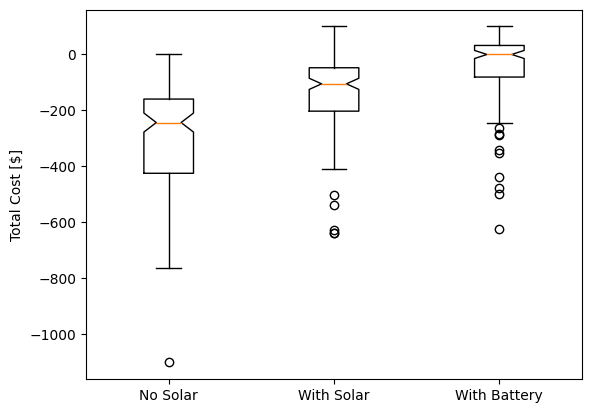

In [8]:
# Plot
plt.boxplot(
    merged[['No Solar Cost', 'Historic Reward', 'Reward_Total']],
    notch=True)
plt.ylabel('Total Cost [$]')
plt.xticks([1, 2, 3], ['No Solar', 'With Solar', 'With Battery'])

([<matplotlib.axis.XTick at 0x1d2468e3430>,
 [Text(1, 0, 'No Solar'),
  Text(2, 0, 'With Solar'),
  Text(3, 0, 'With Battery')])

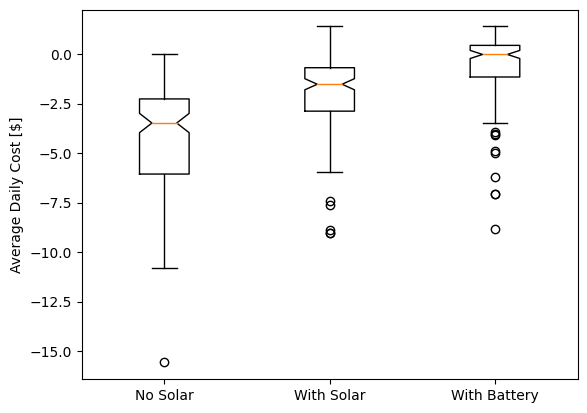

In [9]:
# Plot 
plt.boxplot(
    merged[['Mean No Solar', 'Mean Solar', 'Mean_Daily_Cost']],
    notch=True)
plt.ylabel('Average Daily Cost [$]')
plt.xticks([1, 2, 3], ['No Solar', 'With Solar', 'With Battery'])
